<a href="https://colab.research.google.com/github/Esantomi/NLP/blob/master/NLP_Day6_NaverReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Char RNN

## 네이버 쇼핑 리뷰 감성 분석
- 총 200,000ro 리뷰로 구성  
- 평점이 5점 만점에 1, 2, 4, 5인 리뷰들로 구성
- 평점이 4, 5인 리뷰들에 긍정 1, 부정 0
- 감성 분류 수행

In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [ ]:
!pwd

/content


In [ ]:
ls

Mecab-ko-for-Google-Colab/  sample_data/


In [ ]:
cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [ ]:
ls

images/                                    LICENSE
install_mecab-ko_on_colab190912.sh         README.md
install_mecab-ko_on_colab_light_210108.sh


In [ ]:
!bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 1.5MB/s 
     |████████████████████████████████| 450kB 28.7MB/s 
     |████████████████████████████████| 92kB 7.8MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-06-17 05:10:24--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c3:9b0a, 2406:da00:ff00::6b17:d1f5, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=VxU26vc9FV3JNOomuRLBhcbAMDs%3D&Expires=1623907534&AWSAccessKeyId=AKIA6KOSE3BNJ

In [ ]:
from konlpy.tag import Mecab

In [ ]:
mecab = Mecab()  # mecab 테스트 중

print(mecab.morphs('밥먹고 공부하려니 졸립고 나른하군 ㅠㅠ'))

['밥', '먹', '고', '공부', '하', '려니', '졸립', '고', '나른', '하군', 'ㅠㅠ']


In [ ]:
mecab = Mecab()  # mecab 테스트 중

print(mecab.morphs('도현이는 그러면 이제 내년부터는 본격적으로 석사 생활을 시작하게 되겠군.'))

['도현', '이', '는', '그러면', '이제', '내년', '부터', '는', '본격', '적', '으로', '석사', '생활', '을', '시작', '하', '게', '되', '겠', '군', '.']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 데이터 로드

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7fca897219d0>)

In [ ]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

In [ ]:
print('전체 리뷰 갯수 :', len(total_data))

전체 리뷰 갯수 : 200000


In [ ]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


### 훈련 데이터와 테스트 데이터를 분리

In [ ]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)  # rating이 3보다 크면 label 1

total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [ ]:
# 각 열에 중복을 제외한 샘플의 수를 카운트
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [ ]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) #reviews열에서 중복인 내용이 있다면 중복 제거

print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [ ]:
# NULL값 유무
print(total_data.isnull().values.any())

False


In [ ]:
# 훈련데이터와 테스트 데이터 3:1비율로 나눔
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state=42)
print('훈련용 리뷰의 갯수 :', len(train_data))
print('테스트용 리뷰의 갯수 :', len(test_data))

훈련용 리뷰의 갯수 : 149931
테스트용 리뷰의 갯수 : 49977


### 레이블의 분포 확인

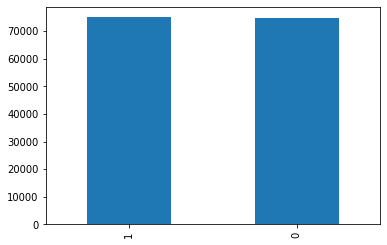

In [ ]:
train_data['label'].value_counts().plot(kind='bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name='count'))  # 수치로 확인

   label  count
0      0  74918
1      1  75013


### 데이터 정제하기

- 정규 표현식을 사용하여 한글을 제외하고 모두 제거  
- 빈 샘플이 생겼는지 확인

In [ ]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")
train_data['reviews'].replace('', np.nan, inplace=True)

print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
test_data.drop_duplicates(subset=['reviews'], inplace=True)
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")
test_data['reviews'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')

print('전처리 후 테스트용 샘플의 갯수 : ',len(test_data))

전처리 후 테스트용 샘플의 갯수 :  49977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

### 토큰화

In [ ]:
mecab = Mecab()

print(mecab.morphs('이런 상품도 상품이라고 허허허'))

['이런', '상품', '도', '상품', '이', '라고', '허허허']


### 불용어 제거

In [ ]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

### 단어의 길이와 분포 확인하기

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
# 부정 리뷰에 대해서 빈도가 높은 상위 20개 단어 출력
# Counter()를 사용하여 각 단어에 대한 빈도수 계산
negative_word_count = Counter(negative_words)

print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [ ]:
positive_word_count = Counter(positive_words)

print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


긍정 리뷰의 평균 길이 : 13.587751456414221
부정 리뷰의 평균 길이 : 17.029525614672043


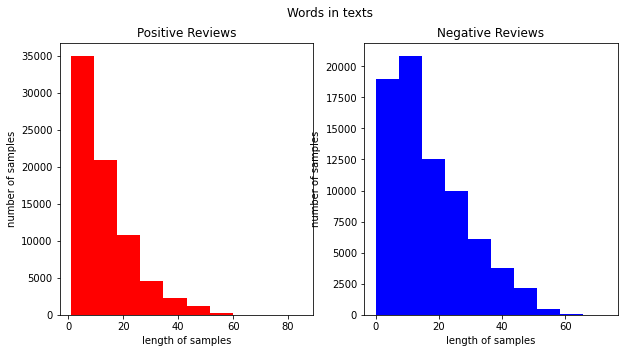

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
text_len = train_data[train_data['label']== 1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color ='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :',np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [ ]:
x_train = train_data['tokenized'].values
y_train = train_data['label'].values
x_test = test_data['tokenized'].values
y_test = test_data['label'].values

### 정수 인코딩

In [ ]:
t = Tokenizer()
t.fit_on_texts(x_train)

In [ ]:
threshold = 2
total_cnt = len(t.word_index)  # 단어의 수
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 key와 value로 받는다.
for key, value in t.word_counts.items():
  total_freq = total_freq + value

  if (value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀단어의 수: %s '% (threshold-1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율 :', (rare_cnt/ total_cnt)*100)
print('전체 등장 빈도에서 희귀단어 등장 빈도 비율: ',(rare_freq/total_freq)*100)

단어 집합(vocabulary)의 크기 : 39997
등장 빈도가 1번 이하인 희귀단어의 수: 18212 
단어 집합에서 희귀 단어의 비율 : 45.53341500612546
전체 등장 빈도에서 희귀단어 등장 빈도 비율:  0.79352492030765


In [ ]:
# 전체 단어 갯수 중 빈도수 2이하인 단어 갯수는 제거
# 0번 패딩 토큰고 1번 OOV토큰을 고려해서 +2
vocab_size = total_cnt - rare_cnt + 2

print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 21787


In [ ]:
original_vocab_size = vocab_size + rare_cnt -2
print('원래 vocab size :', original_vocab_size)

원래 vocab size : 39997


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
print(x_train[:3])
print(x_test[:3])

[[67, 2060, 299, 14260, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]
[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


### 패딩

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.30754813881052


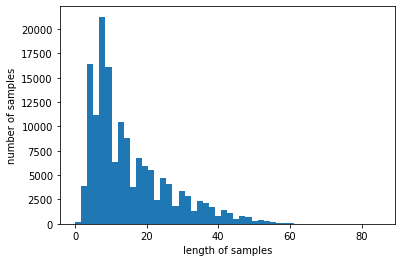

In [ ]:
print('리뷰의 최대 길이 :', max(len(l) for l in x_train))
print('리뷰의 평균 길이 :', sum(map(len, x_train))/len(x_train))
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if (len(s) <= max_len):
      cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (cnt/len(nested_list))*100))

In [ ]:
max_len = 80
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율 : 99.99933302652553


In [ ]:
x_train = pad_sequences(x_train, maxlen= max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(149931, 80)
(49977, 80)


### GRU 모델로 학습하기

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs= 30, callbacks=[es, mc], batch_size = 60, validation_split=0.2)

Epoch 1/30
2000/2000 [==============================] - 320s 158ms/step - loss: 0.2670 - acc: 0.8983 - val_loss: 0.2412 - val_acc: 0.9087

Epoch 00001: val_acc improved from -inf to 0.90873, saving model to best_model.h5
Epoch 2/30
2000/2000 [==============================] - 318s 159ms/step - loss: 0.1944 - acc: 0.9302 - val_loss: 0.2154 - val_acc: 0.9213

Epoch 00002: val_acc improved from 0.90873 to 0.92130, saving model to best_model.h5
Epoch 3/30
2000/2000 [==============================] - 317s 159ms/step - loss: 0.1601 - acc: 0.9435 - val_loss: 0.2223 - val_acc: 0.9192

Epoch 00003: val_acc did not improve from 0.92130
Epoch 4/30
2000/2000 [==============================] - 315s 158ms/step - loss: 0.1327 - acc: 0.9529 - val_loss: 0.2505 - val_acc: 0.9126

Epoch 00004: val_acc did not improve from 0.92130
Epoch 5/30
2000/2000 [==============================] - 317s 159ms/step - loss: 0.1090 - acc: 0.9613 - val_loss: 0.2899 - val_acc: 0.9123

Epoch 00005: val_acc did not improve f

In [ ]:
loaded_model = load_model('best_model.h5')

print('\n 테스트 정확도 : %.4f'% (loaded_model.evaluate(x_test, y_test)[1]))

1562/1562 [==============================] - 34s 22ms/step - loss: 0.2196 - acc: 0.9200

 테스트 정확도 : 0.9200


### 리뷰 예측하기

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) #토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords]  #불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen=max_len) # 패딩

  score = float(loaded_model.predict(pad_new)) #d예측

  if (score >0.5):
    print('{:.2f}%확률로 긍정 리뷰입니다.'.format(score*100))
  else:
    print('{:.2f}%확률로 부정 리뷰입니다.'.format((1-score)*100))

In [ ]:
sentiment_predict('이 상품 진짜 좋아요.. 저는 강추 대박')

97.79%확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('이 상품 별로에요..')

98.90%확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('진짜 배송 늦고 개별로 개짜증')

99.25%확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('그냥 그래요')

99.40%확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('ㄴㅇㄹㄴㅇㄹㄴㅇㄹㄴㅇㄹㅇㄴ귀찮아')

68.25%확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('너무 짱이에요')

98.07%확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('받아서 뜯었는데 적당하고 좋네요 다만 배송에는 신경써야할듯')

94.54%확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('배송 이따위로 하지 마세요 안에 다 터져서 줄줄 샘. 제품 자체는 문제 없음')

99.56%확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('고기가 파란빛깔이라 남편 말고 우리집 개 줬더니 맛있게 먹네요.')

91.66%확률로 긍정 리뷰입니다.
